In [28]:

# Debug Wand Detection - Enhanced Visuals
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]

import cv2
import numpy as np
import os

# Target frame (Hard Mode Dataset)
IMG_PATH = r"H:\20260106\T0\cam3\frame000041.tif"
OUT_DIR = r"d:\0.Code\OpenLPTGUI\OpenLPT"

# Parameters
LPT_MIN_R = 50.0
LPT_MAX_R = 100.0
FAST_ANNULUS_LOW = 0.7
FAST_ANNULUS_HIGH = 1.3
RANSAC_THRESH = 3.0
RANSAC_ITERS = 500


In [29]:

def draw_dashed_circle(img, center, radius, color, thickness=1, dash_len=10):
    cx, cy = int(center[0]), int(center[1])
    r = int(radius)
    if dash_len <= 0:
        cv2.circle(img, (cx, cy), r, color, thickness, cv2.LINE_AA)
        return
    for angle in range(0, 360, dash_len * 2):
        cv2.ellipse(img, (cx, cy), (r, r), 0, angle, angle + dash_len, color, thickness, cv2.LINE_AA)

def thin_by_angle(pts, cx, cy, r_init, nbin=360):
    # One point per degree
    ang = np.arctan2(pts[:,1]-cy, pts[:,0]-cx)
    bins = ((ang + np.pi)/(2*np.pi)*nbin).astype(int)
    bins = np.clip(bins, 0, nbin-1)
    keep = []
    for b in range(nbin):
        idx = np.where(bins == b)[0]
        if idx.size == 0: continue
        # Approach: Pick point closest to R_INIT
        dists = np.sqrt((pts[idx,0]-cx)**2 + (pts[idx,1]-cy)**2)
        dist_diff = np.abs(dists - r_init)
        best_i = idx[np.argmin(dist_diff)]
        keep.append(best_i)
    return pts[np.array(keep)]


Step 1: Binarization (Otsu)


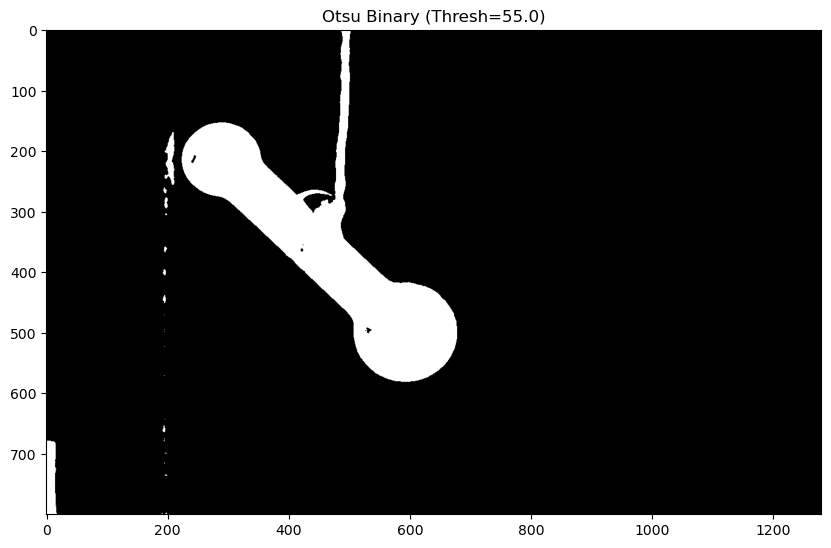

Step 1.5: Fill Holes


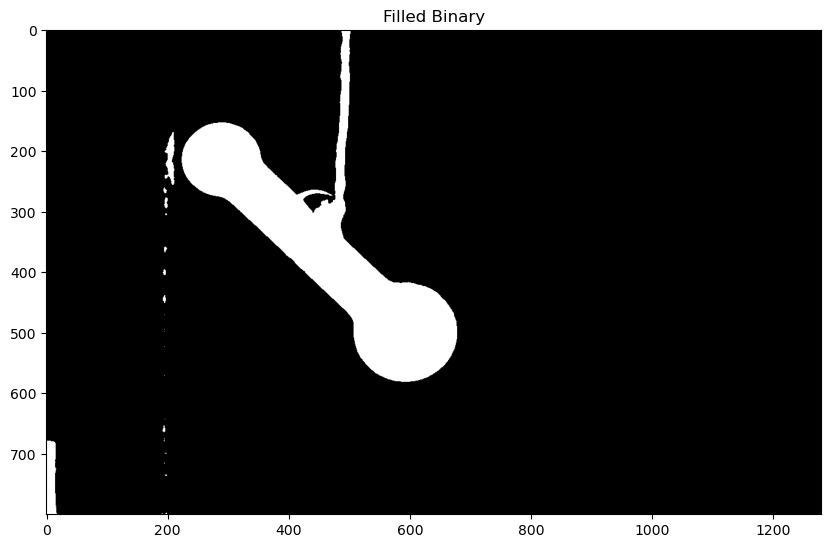

Step 2: Canny Edge Detection


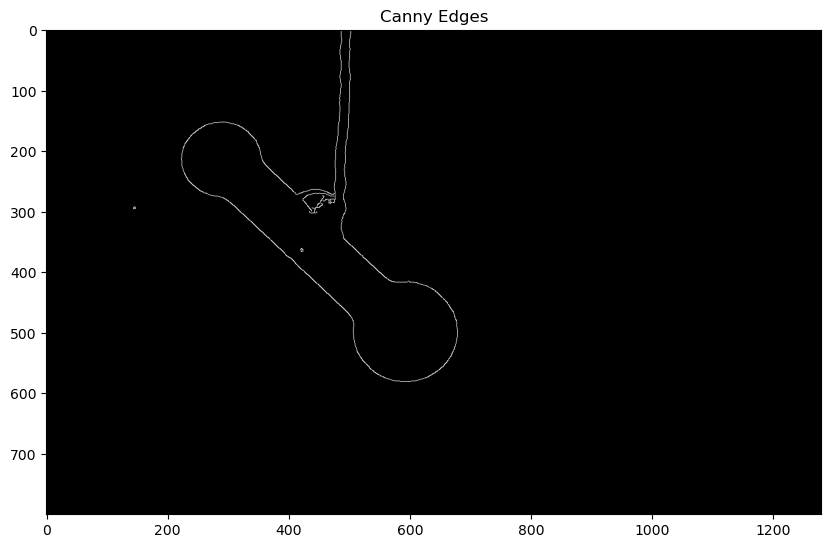

Step 2: Distance Transform Map


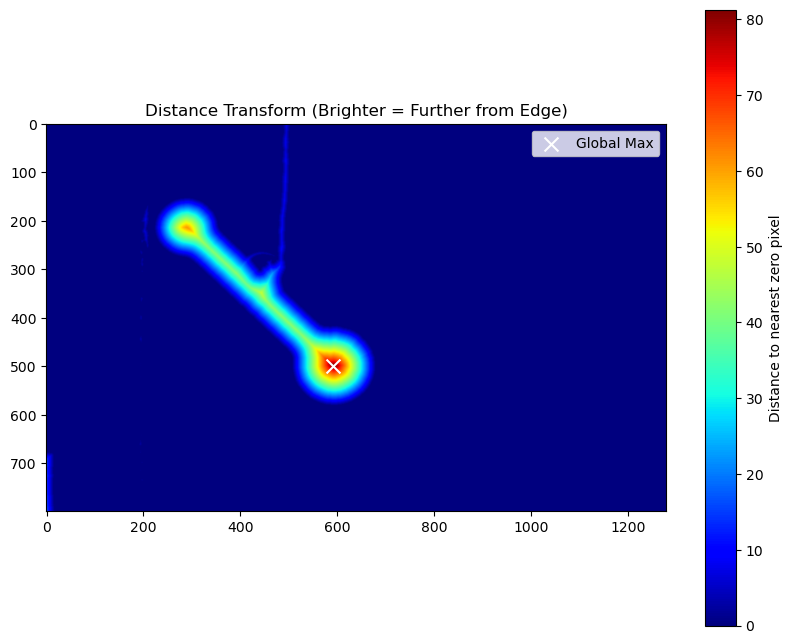

Step 3: Found 2 candidates via DT.


In [30]:

if not os.path.exists(IMG_PATH):
    print(f"Error: File not found at {IMG_PATH}")
else:
    img_bgr = cv2.imread(IMG_PATH)
    if img_bgr is None:
        print("Failed to load image.")
    else:
        # 1. Grayscale
        img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
        
        # 2. Blur & Otsu
        img_blur = cv2.GaussianBlur(img_gray, (5, 5), 0)
        thresh_val, img_bin = cv2.threshold(img_blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        
        # Plot Binary
        print("Step 1: Binarization (Otsu)")
        plt.figure(figsize=(10, 8))
        plt.title(f"Otsu Binary (Thresh={thresh_val})")
        plt.imshow(img_bin, cmap='gray')
        plt.show()

        # 1.5 Fill Holes (填补孔洞)
        contours, _ = cv2.findContours(img_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        img_bin_filled = np.zeros_like(img_bin)
        cv2.drawContours(img_bin_filled, contours, -1, 255, cv2.FILLED)
        img_bin = img_bin_filled  # 更新 img_bin 为填补后的图像
        # Plot Filled (可视化结果)
        print("Step 1.5: Fill Holes")
        plt.figure(figsize=(10, 8))
        plt.title("Filled Binary")
        plt.imshow(img_bin, cmap='gray')
        plt.show()


        # 3. Canny
        edges = cv2.Canny(img_blur, 30, 80)
        
        # Plot Canny
        print("Step 2: Canny Edge Detection")
        plt.figure(figsize=(10, 8))
        plt.title("Canny Edges")
        plt.imshow(edges, cmap='gray')
        plt.show()

        # 4. Distance Transform
        dist = cv2.distanceTransform(img_bin, cv2.DIST_L2, 5)
                # --- 插入到 cv2.distanceTransform 之后 ---

        # Plot Distance Transform (DT 辐射图)
        print("Step 2: Distance Transform Map")
        plt.figure(figsize=(10, 8))
        plt.title("Distance Transform (Brighter = Further from Edge)")
        # 使用 'jet' 或 'plasma' 配色能看得更清楚
        plt.imshow(dist, cmap='jet') 
        plt.colorbar(label='Distance to nearest zero pixel')
        
        # 标出全局最大值点（即大概的中心）
        minVal, maxVal, minLoc, maxLoc = cv2.minMaxLoc(dist)
        plt.scatter(maxLoc[0], maxLoc[1], c='white', marker='x', s=100, label='Global Max')
        plt.legend()
        plt.show()

        # 5. Peak Finding
        min_dist_r = LPT_MIN_R
        peaks = []
        
        dist_search = dist.copy()
        # Initial candidates loop
        while True:
            min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(dist_search)
            if max_val < min_dist_r:
                break
            
            cx, cy = max_loc
            r_init = max_val
            peaks.append((cx, cy, r_init))
            
            # Mask out this region
            cv2.circle(dist_search, (cx, cy), int(r_init * 1.2), 0, -1)
            
            if len(peaks) >= 10: break
            
        print(f"Step 3: Found {len(peaks)} candidates via DT.")



Processing Candidate 0: Init (x=592, y=499, r=81.3)


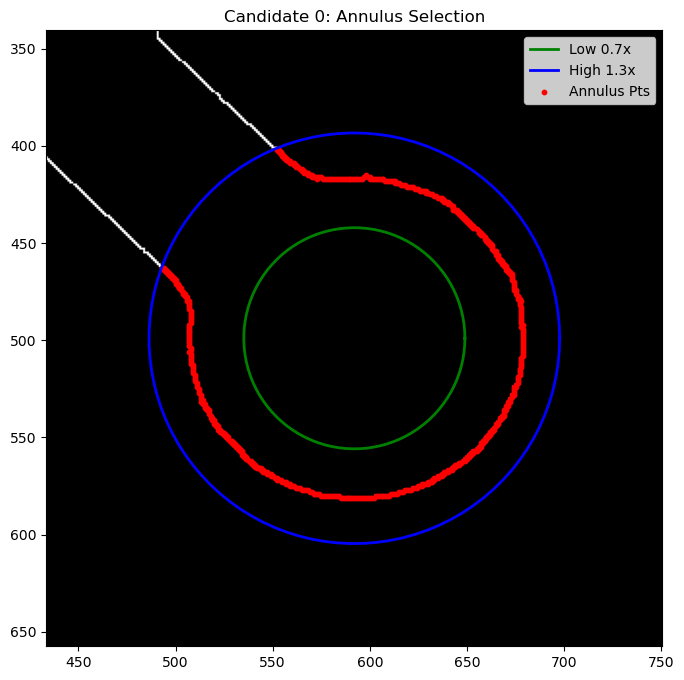

  Raw: 562 -> Thinned: 314
  Best RANSAC: R=85.96, Metric=12.4649
  Refined LS: R=85.86, C=(592.8, 495.9)


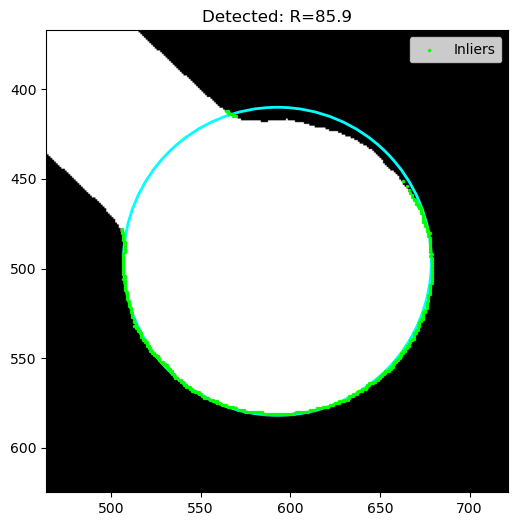


Processing Candidate 1: Init (x=290, y=215, r=60.7)


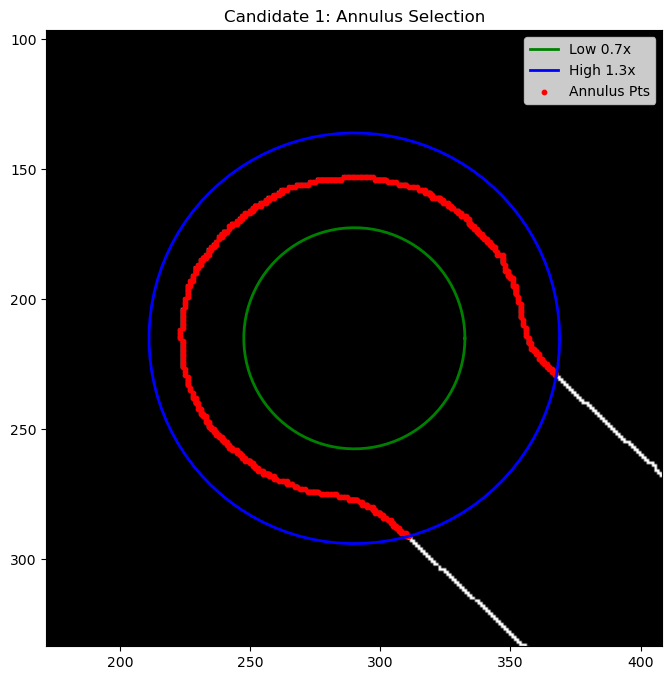

  Raw: 409 -> Thinned: 287
  Best RANSAC: R=66.49, Metric=8.9617
  Refined LS: R=66.39, C=(289.7, 219.2)


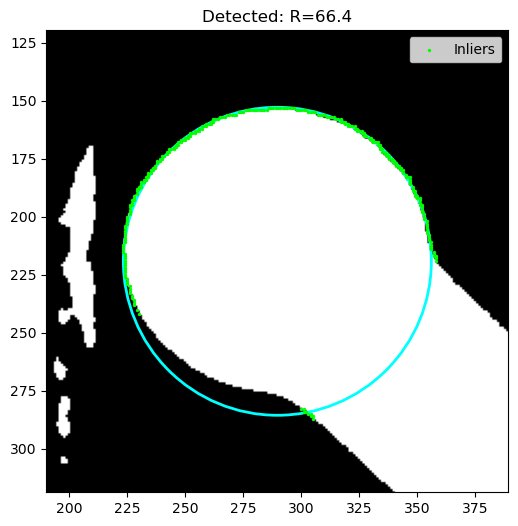

In [31]:

# Process Peaks
edge_pts_all = np.column_stack(np.where(edges > 0)) # y, x
edge_pts_all = edge_pts_all[:, [1, 0]] # x, y

for i, (cx, cy, r_init) in enumerate(peaks):
    print(f"\nProcessing Candidate {i}: Init (x={cx}, y={cy}, r={r_init:.1f})")
    
    # 1. Select Annulus Points
    r_min = r_init * FAST_ANNULUS_LOW
    r_max = r_init * FAST_ANNULUS_HIGH
    
    dists = np.sqrt((edge_pts_all[:,0]-cx)**2 + (edge_pts_all[:,1]-cy)**2)
    mask = (dists >= r_min) & (dists <= r_max)
    pts_raw = edge_pts_all[mask]
    
    # VISUALIZATION: Plot Annulus & Points
    plt.figure(figsize=(8,8))
    # Show Canny Edges as background
    plt.imshow(edges, cmap='gray')
    ax = plt.gca()
    
    # Draw Annulus Bounds
    u = np.linspace(0, 2*np.pi, 100)
    ax.plot(cx + r_min*np.cos(u), cy + r_min*np.sin(u), 'g-', linewidth=2, label=f'Low {FAST_ANNULUS_LOW}x')
    ax.plot(cx + r_max*np.cos(u), cy + r_max*np.sin(u), 'b-', linewidth=2, label=f'High {FAST_ANNULUS_HIGH}x')
    
    # Draw Selected Points
    if len(pts_raw) > 0:
        ax.scatter(pts_raw[:,0], pts_raw[:,1], c='r', s=10, label='Annulus Pts')
    
    plt.title(f"Candidate {i}: Annulus Selection")
    plt.legend()
    # Zoom in
    plt.xlim(cx - r_max*1.5, cx + r_max*1.5)
    plt.ylim(cy + r_max*1.5, cy - r_max*1.5) # Invert Y for image coords
    plt.show()

    if len(pts_raw) < 10:
        print("  Not enough points in annulus.")
        continue

    # 2. Thinning
    pts_thinned = thin_by_angle(pts_raw, cx, cy, r_init)
    print(f"  Raw: {len(pts_raw)} -> Thinned: {len(pts_thinned)}")
    
    if len(pts_thinned) < 5:
        print("  Not enough thinned points.")
        continue
        
    # 3. RANSAC
    best_score = -1.0
    best_model = None
    
    pts = pts_thinned
    n_pts = pts.shape[0]
    
    for _ in range(RANSAC_ITERS):
        if n_pts < 3: break
        sample_idx = np.random.choice(n_pts, 3, replace=False)
        p3 = pts[sample_idx]
        
        # Circle from 3 points
        A = np.column_stack((p3[:,0], p3[:,1], np.ones(3)))
        B = -(p3[:,0]**2 + p3[:,1]**2)
        try:
            X, residuals, rank, s = np.linalg.lstsq(A, B, rcond=None)
            D, E, F = X.flatten()
            xc = -D/2
            yc = -E/2
            rc = np.sqrt(xc**2 + yc**2 - F)
        except:
            continue
            
        if not (LPT_MIN_R <= rc <= LPT_MAX_R): continue
        if np.abs(rc - r_init) > r_init * 0.4: continue # Sanity check
        
        # Score
        d_all = np.sqrt((pts[:,0]-xc)**2 + (pts[:,1]-yc)**2)
        res = np.abs(d_all - rc)
        inliers = res < RANSAC_THRESH
        n_in = np.sum(inliers)
        
        if n_in < 10: continue
        
        # Coverage
        angles = np.arctan2(pts[inliers,1]-yc, pts[inliers,0]-xc)
        # Uniformity metric (simple histogram)
        hist, _ = np.histogram(angles, bins=72, range=(-np.pi, np.pi))
        n_bins_covered = np.count_nonzero(hist > 0)
        coverage = n_bins_covered / 72.0
        
        # Metric
        mean_res = np.mean(res[inliers])
        metric = (coverage**2 * np.sqrt(n_in)) / (mean_res + 1e-5)
        
        if metric > best_score:
            best_score = metric
            best_model = (xc, yc, rc)
            
    if best_model:
        xc, yc, rc = best_model
        print(f"  Best RANSAC: R={rc:.2f}, Metric={best_score:.4f}")
        
        # 4. Refine (Using all raw inliers)
        d_raw = np.sqrt((pts_raw[:,0]-xc)**2 + (pts_raw[:,1]-yc)**2)
        inliers_raw = np.abs(d_raw - rc) < RANSAC_THRESH
        pts_final = pts_raw[inliers_raw]
        
        if len(pts_final) > 5:
            # Kasa fitting
            xi = pts_final[:,0]
            yi = pts_final[:,1]
            M = np.column_stack((xi, yi, np.ones_like(xi)))
            zi = xi**2 + yi**2
            P, _, _, _ = np.linalg.lstsq(M, zi, rcond=None)
            Ux, Uy, F = P
            xc_f = Ux/2
            yc_f = Uy/2
            rc_f = np.sqrt(Ux**2/4 + Uy**2/4 + F)
            print(f"  Refined LS: R={rc_f:.2f}, C=({xc_f:.1f}, {yc_f:.1f})")
            
            # FINAL Plot
            plt.figure(figsize=(6,6))
            plt.imshow(img_bin, cmap='gray')
            ax = plt.gca()
            circle = plt.Circle((xc_f, yc_f), rc_f, color='cyan', fill=False, linewidth=2)
            ax.add_patch(circle)
            ax.scatter(pts_final[:,0], pts_final[:,1], c='lime', s=2, label='Inliers')
            plt.title(f"Detected: R={rc_f:.1f}")
            plt.legend()
            plt.xlim(xc_f - rc_f*1.5, xc_f + rc_f*1.5)
            plt.ylim(yc_f + rc_f*1.5, yc_f - rc_f*1.5)
            plt.show()

